# Batch Gradient Descent With a Single Neuron

*Tue Sep 14, Week 3, Lecture 5*

## Why Python and why Jupyter Notebooks?

- Python is not an ideal langauge for this
- Jupyter is not an ideal environment for htis
- They are, however, in my opinion the **best** we have 

## Notes

- In this example, I am not going to do fancy imports
- I want you to see the layout of torch and torchvision

In [1]:
import torch
import torchvision
import pandas as pd

In [2]:
torch.rand(5)

tensor([0.3502, 0.7085, 0.0488, 0.9742, 0.4776])

In [3]:
torch.rand(5).shape

torch.Size([5])

In [ ]:
torch.rand(5, 25)

In [5]:
torch.rand(5, 25).shape

torch.Size([5, 25])

In [6]:
X = torch.rand(5, 12)
Y = torch.rand(12, 16)

In [7]:
X.shape, Y.shape

(torch.Size([5, 12]), torch.Size([12, 16]))

In [ ]:
X

In [ ]:
X @ Y

In [10]:
Z = X @ Y

In [11]:
X.shape, Y.shape

(torch.Size([5, 12]), torch.Size([12, 16]))

In [12]:
Z.shape

torch.Size([5, 16])

In [13]:
Y @ Z

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x16 and 5x16)

In [ ]:
# MNIST : hello world
# EMNIST : extended with letters in addition to digits
# KMNIST : Kuzushiji, Japanese characters
# QMNIST : newer MNIST with better source information

data_path = "../data/"

mnist_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root=data_path, train=True, download=True, transform=mnist_transforms
)

In [15]:
# batch_size, shuffle
train_loader = torch.utils.data.DataLoader(train_dataset)

In [16]:
image, label = next(iter(train_loader))

In [17]:
image.shape

torch.Size([1, 1, 28, 28])

In [18]:
label.shape, label

(torch.Size([1]), tensor([5]))

In [ ]:
image

In [ ]:
mnist_avg, mnist_std = 0.130, 0.3081

image = torch.as_tensor((image * mnist_std + mnist_avg) * 255, dtype=torch.uint8)
image

In [ ]:
image_df = pd.DataFrame(image.squeeze().numpy())
image_df

In [22]:
image_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,2,17,17,17,125,135,174,25,165,254,246,126,0,0,0,0
6,0,0,0,0,0,0,0,0,29,35,93,153,169,252,252,252,252,252,224,171,252,241,194,63,0,0,0,0
7,0,0,0,0,0,0,0,48,237,252,252,252,252,252,252,252,252,250,92,81,81,55,38,0,0,0,0,0
8,0,0,0,0,0,0,0,17,218,252,252,252,252,252,197,181,246,240,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,79,155,106,252,252,204,10,0,42,153,0,0,0,0,0,0,0,0,0,0


In [23]:
import matplotlib.pyplot as plt

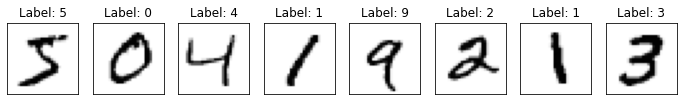

In [24]:
num_to_show = 8

fig, axes = plt.subplots(1, num_to_show, figsize=(12, 12))

for axis, (image, label) in zip(axes, train_loader):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_title(f"Label: {label[0]}")

# A Single Neuron Model

In [25]:
# Simple single neuron model; sometimes called logistic regression

num_pixels = 28 * 28

# Neuron parameters
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

In [26]:
weights.shape, bias.shape, image[0].shape, image[0].view(num_pixels, 1).shape

(torch.Size([784, 1]),
 torch.Size([1]),
 torch.Size([1, 28, 28]),
 torch.Size([784, 1]))

In [27]:
x = image[0]

In [28]:
weights @ x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 1x784)

In [29]:
x = image[0].view(num_pixels, 1)

In [30]:
weights @ x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (784x1 and 784x1)

In [31]:
weights.T @ x

tensor([[0.1773]])

In [32]:
# from torch import FloatTensor, FloatType


def linear(w, b, x):
    return w.T @ x + b

In [33]:
linear(weights, bias, x)

tensor([[0.1773]])

In [34]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [35]:
sigmoid(linear(weights, bias, x))

tensor([[0.5442]])

# Let's Focus on Binary Classification

In [36]:
# Get down to two classes (let them pick)

class1 = 7
class2 = 1

idx1 = [i for i, t in enumerate(train_dataset.targets) if t == class1]
idx2 = [i for i, t in enumerate(train_dataset.targets) if t == class2]

idxs = idx1 + idx2
train_size = len(idxs)

train_loader2 = torch.utils.data.DataLoader(
    train_dataset, sampler=torch.utils.data.SubsetRandomSampler(idxs)
)

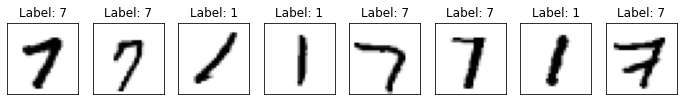

In [37]:
num_to_show = 8

fig, axes = plt.subplots(1, num_to_show, figsize=(12, 12))

for axis, (image, label) in zip(axes, train_loader2):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_title(f"Label: {label[0]}")

# Using Our Derived Equations

In [38]:
from time import time

In [39]:
# Optimization, binary cross-entropy loss (Log loss, aka logistic loss or cross-entropy loss)
# defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true

# compare with: subtraction, MSE, abs


def target_to_sigmoid(target):
    new_target = torch.zeros_like(target)
    new_target[target == class1] = 1
    return new_target


# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

for epoch in range(num_epochs):

    cost = 0
    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    for image, target in train_loader2:

        image = image.view(num_pixels, 1)
        target = target_to_sigmoid(target)

        prediction = sigmoid(linear(weights, bias, image))

        loss = target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction)
        cost -= loss

        dz = prediction - target
        weights_derivatives += image * dz
        bias_derivative += dz.squeeze()

    weights_derivatives /= len(train_loader2)
    bias_derivative /= len(train_loader2)

    weights -= learning_rate * weights_derivatives
    bias -= learning_rate * bias_derivative

    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost[0][0]:0.1f}, Time={time()-start:0.1f}s"
    )

 1/4, Cost=9051.6, Time=6.4s
 2/4, Cost=6885.9, Time=6.3s
 3/4, Cost=5558.1, Time=6.3s
 4/4, Cost=4690.5, Time=6.3s


# Let's Compute All At Once (Batch GD)

In [40]:
# Set the batch size to be equal to the size of the training dataset
train_loader2All = torch.utils.data.DataLoader(
    train_dataset,
    sampler=torch.utils.data.SubsetRandomSampler(idxs),
    batch_size=train_size,
)

In [41]:
# Vectorize (operate on all images at once)

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    images, targets = next(iter(train_loader2All))
    # print(len(images), images.shape, images.view(train_size, num_pixels))

    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)

    predictions = sigmoid(linear(weights, bias, images.T))
    # print(predictions.shape, targets.shape)

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1 / train_size) * (dZ @ images)
    bias_derivative = (1 / train_size) * dZ.sum()

    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative

    print(f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Time={time()-start:0.1f}s")

 1/4, Cost=9489.4, Time=2.7s
 2/4, Cost=7091.1, Time=2.6s
 3/4, Cost=5644.4, Time=2.6s
 4/4, Cost=4717.2, Time=2.6s


# Is This Better? Need a Metric

In [42]:
# Create the validation dataset

valid_dataset = torchvision.datasets.MNIST(
    root=data_path, train=False, download=True, transform=mnist_transforms
)

idx1 = [i for i, t in enumerate(valid_dataset.targets) if t == class1]
idx2 = [i for i, t in enumerate(valid_dataset.targets) if t == class2]

valid_idxs = idx1 + idx2
valid_size = len(valid_idxs)

print(valid_size)

valid_loader2All = torch.utils.data.DataLoader(
    valid_dataset,
    sampler=torch.utils.data.SubsetRandomSampler(valid_idxs),
    batch_size=valid_size,
)

2163


In [43]:
# Add validation metric

# Neuron parameters
num_pixels = 28 * 28
weights = torch.randn(num_pixels, 1) * 0.01
bias = torch.zeros(1)

num_epochs = 4
learning_rate = 0.01

# Validate with accuracy
valid_images, valid_targets = next(iter(valid_loader2All))
valid_images = valid_images.view(valid_size, num_pixels)
valid_targets = target_to_sigmoid(valid_targets)

valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

accuracy = 1 - (torch.round(valid_predictions) - valid_targets).abs().sum() / valid_size

print(f"Accuracy={accuracy:.2f}")

for epoch in range(num_epochs):

    weights_derivatives = torch.zeros_like(weights)
    bias_derivative = torch.zeros_like(bias)

    start = time()

    images, targets = next(iter(train_loader2All))
    images = images.view(train_size, num_pixels)
    targets = target_to_sigmoid(targets)

    predictions = sigmoid(linear(weights, bias, images.T))

    loss = targets * torch.log(predictions) + (1 - targets) * torch.log(1 - predictions)
    cost = -loss.sum()

    dZ = predictions - targets
    weights_derivatives = (1 / train_size) * (dZ @ images)
    bias_derivative = (1 / train_size) * dZ.sum()

    weights -= learning_rate * weights_derivatives.T
    bias -= learning_rate * bias_derivative

    # Validate with accuracy
    valid_images, valid_targets = next(iter(valid_loader2All))
    valid_images = valid_images.view(valid_size, num_pixels)
    valid_targets = target_to_sigmoid(valid_targets)

    valid_predictions = sigmoid(linear(weights, bias, valid_images.T))

    accuracy = (
        1 - (torch.round(valid_predictions) - valid_targets).abs().sum() / valid_size
    )

    print(
        f"{epoch+1:>2}/{num_epochs}, Cost={cost:0.1f}, Accuracy={accuracy:.2f}, Time={time()-start:0.1f}s"
    )

Accuracy=0.46
 1/4, Cost=9036.0, Accuracy=0.95, Time=3.1s
 2/4, Cost=6784.2, Accuracy=0.96, Time=3.1s
 3/4, Cost=5442.1, Accuracy=0.96, Time=3.0s
 4/4, Cost=4581.2, Accuracy=0.96, Time=3.0s


In [44]:
valid_predictions.shape

torch.Size([1, 2163])

In [45]:
valid_targets.shape

torch.Size([2163])

In [46]:
valid_predictions[:10]

tensor([[0.8139, 0.7805, 0.2555,  ..., 0.1953, 0.2259, 0.8097]])

In [47]:
torch.round(valid_predictions)

tensor([[1., 1., 0.,  ..., 0., 0., 1.]])

In [48]:
(torch.round(valid_predictions) - valid_targets).sum()

tensor(-69.)

In [49]:
(torch.round(valid_predictions) - valid_targets).sum()/valid_size

tensor(-0.0319)

In [50]:
1 - (torch.round(valid_predictions) - valid_targets).sum()/valid_size

tensor(1.0319)

In [51]:
x = 1 - (torch.round(valid_predictions) - valid_targets).sum()/valid_size

In [52]:
f"Accuracy={x:.2f}"

'Accuracy=1.03'